In [1]:
!mkdir -p ~/.kaggle
!cp /content/kaggle\ \(2\).json ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d anjana22/concrete-crack-detection

Dataset URL: https://www.kaggle.com/datasets/anjana22/concrete-crack-detection
License(s): unknown
100% 1.14G/1.14G [01:08<00:00, 20.9MB/s]
100% 1.14G/1.14G [01:08<00:00, 17.9MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/concrete-crack-detection.zip",'r')
zip.extractall("/content")
zip.close()

(40003,)


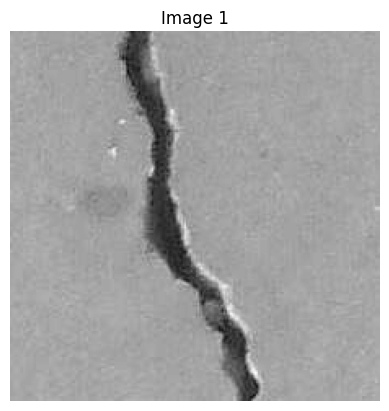

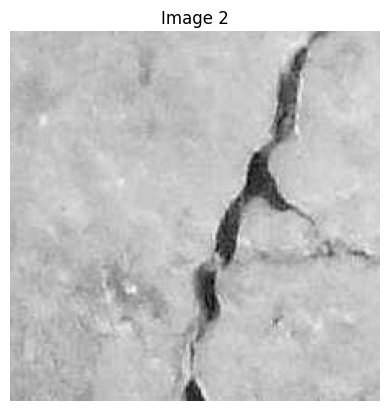

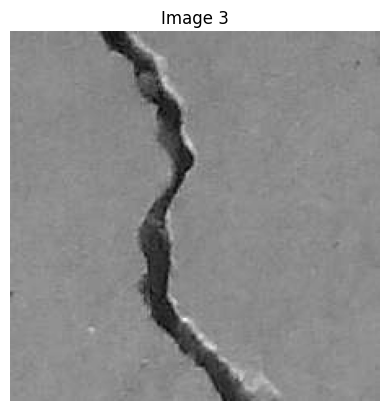

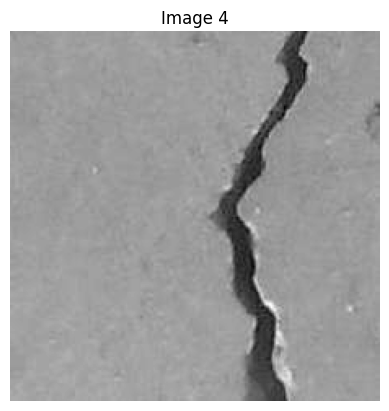

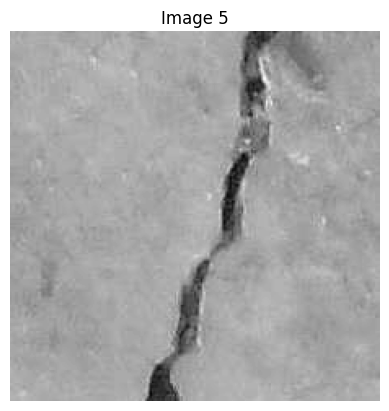

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file with allow_pickle=True
images = np.load('/content/train.npy', allow_pickle=True)

# Check the shape of the array to ensure it's correct
print(images.shape)

# Display the first 5 images
for i in range(5):
    plt.figure()
    plt.imshow(images[i], cmap='gray')  # Change cmap depending on the image type (RGB or grayscale)
    plt.title(f'Image {i+1}')
    plt.axis('off')  # Hide the axes
    plt.show()


In [5]:
import zipfile
import os

# Define paths
zip_path = '/content/concrete-crack-detection.zip'
extract_dir = '/content/concrete-crack-detection'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")


Dataset extracted to /content/concrete-crack-detection


In [6]:
import os

# List all .npy files in the extracted directory
npy_files = [f for f in os.listdir(extract_dir) if f.endswith('.npy')]
print("Found .npy files:")
for file in npy_files:
    print(file)


Found .npy files:
train.npy


In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset

class ConcreteCrackDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir) if fname.endswith('.npy')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = np.load(img_path, allow_pickle=True)
        except Exception as e:
            print(f"Error loading file {img_path}: {e}")
            raise ValueError(f"Failed to load file {img_path}: {e}")

        # Debugging: Print the shape and type of the image
        print(f"Loaded file {img_path} with shape {img.shape} and type {type(img)}")

        if isinstance(img, np.ndarray):
            # Ensure image is in the expected format (example: grayscale images)
            if img.ndim == 3 and img.shape[2] == 1:
                img = img.squeeze(-1)  # Remove single-channel dimension

            img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
            img = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor

            if self.transform:
                img = self.transform(img)
        else:
            raise ValueError("Loaded data is not in a recognized format.")

        return img


In [8]:
from torch.utils.data import DataLoader

# Instantiate the dataset
dataset = ConcreteCrackDataset(dataset_dir=extract_dir)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

print("DataLoader setup complete.")


DataLoader setup complete.


In [9]:
import numpy as np

# Path to one .npy file
test_file_path = '/content/concrete-crack-detection/train.npy'

# Load and inspect the data
try:
    data = np.load(test_file_path, allow_pickle=True)
    print(f"Data shape: {data.shape}")
    print(f"Data type: {type(data)}")
    print(f"Data content sample: {data[:5]}")  # Print a sample of the data
except Exception as e:
    print(f"Error loading file {test_file_path}: {e}")


Data shape: (40003,)
Data type: <class 'numpy.ndarray'>
Data content sample: [array([[133, 134, 137, ..., 139, 139, 139],
        [135, 136, 137, ..., 139, 139, 139],
        [139, 138, 138, ..., 139, 139, 139],
        ...,
        [138, 139, 139, ..., 140, 140, 140],
        [138, 139, 139, ..., 140, 140, 140],
        [138, 139, 139, ..., 140, 140, 140]], dtype=uint8)
 array([[153, 154, 154, ..., 159, 158, 157],
        [155, 155, 155, ..., 159, 158, 157],
        [156, 156, 156, ..., 158, 158, 157],
        ...,
        [139, 141, 143, ..., 154, 153, 152],
        [141, 142, 144, ..., 154, 153, 152],
        [144, 144, 144, ..., 154, 153, 152]], dtype=uint8)
 array([[136, 134, 132, ..., 129, 130, 132],
        [137, 135, 134, ..., 130, 131, 133],
        [138, 136, 135, ..., 133, 133, 134],
        ...,
        [141, 141, 141, ..., 136, 136, 136],
        [141, 141, 141, ..., 136, 136, 136],
        [141, 141, 141, ..., 136, 136, 136]], dtype=uint8)
 array([[137, 140, 144, ..., 146

In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class ConcreteCrackDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.data = np.load(dataset_path, allow_pickle=True)
        self.transform = transform

        # Filter out non-2D arrays during initialization
        self.data = [img for img in self.data if isinstance(img, np.ndarray) and img.ndim == 2]
        if len(self.data) == 0:
            raise ValueError("No valid 2D arrays found in the dataset.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]

        # Normalize and add channel dimension
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            img = self.transform(img)

        return img

# Example usage
dataset_path = '/content/concrete-crack-detection/train.npy'
dataset = ConcreteCrackDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

# Check data
for batch in dataloader:
    print(batch.shape)  # Check the shape of each batch
    # Example: Proceed with feeding the batch into your VAE model


torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class ConcreteCrackDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.data = np.load(dataset_path, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]

        # Check if img is a NumPy array and has 2D shape
        if isinstance(img, np.ndarray) and img.ndim == 2:
            img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

            if self.transform:
                img = self.transform(img)
        else:
            raise ValueError(f"Data at index {idx} is not a 2D numpy array.")

        return img

# Example usage
dataset_path = '/content/concrete-crack-detection/train.npy'
dataset = ConcreteCrackDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)


In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class ConcreteCrackDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.data = np.load(dataset_path, allow_pickle=True)
        self.transform = transform

        # Filter out non-2D arrays during initialization
        self.data = [img for img in self.data if isinstance(img, np.ndarray) and img.ndim == 2]
        if len(self.data) == 0:
            raise ValueError("No valid 2D arrays found in the dataset.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]

        # Normalize and add channel dimension
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            img = self.transform(img)

        return img

# Example usage
dataset_path = '/content/concrete-crack-detection/train.npy'
dataset = ConcreteCrackDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

# Check data
for batch in dataloader:
    print(batch.shape)  # Check the shape of each batch
    # Example: Proceed with feeding the batch into your VAE model


torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size([32, 1, 227, 227])
torch.Size

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.img_size = 227  # Image size
        self.fc1 = nn.Linear(self.img_size * self.img_size, 400)  # Flatten size
        self.fc21 = nn.Linear(400, 20)  # mu
        self.fc22 = nn.Linear(400, 20)  # logvar
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, self.img_size * self.img_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, self.img_size * self.img_size)  # Flatten image
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z).view(-1, 1, self.img_size, self.img_size), mu, logvar


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleModel(nn.Module):
    def __init__(self, img_size):
        super(SimpleModel, self).__init__()
        self.img_size = img_size  # Image size
        self.fc1 = nn.Linear(self.img_size * self.img_size, 400)  # Flatten size
        self.fc2 = nn.Linear(400, self.img_size * self.img_size)  # Output size

    def forward(self, x):
        # Flatten the image
        x = x.view(-1, self.img_size * self.img_size)  # Flattening
        print("Flattened shape:", x.shape)

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Unflatten back to image shape
        x = x.view(-1, 1, self.img_size, self.img_size)  # Unflattening
        print("Unflattened shape:", x.shape)

        return x

# Image size
img_size = 227

# Instantiate model
model = SimpleModel(img_size)

# Create a dummy batch of images with size [batch_size, 1, 227, 227]
batch = torch.randn(16, 1, img_size, img_size)

# Pass batch through model
output = model(batch)


Flattened shape: torch.Size([16, 51529])
Unflattened shape: torch.Size([16, 1, 227, 227])


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, img_size):
        super(Autoencoder, self).__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the image
            nn.Linear(self.img_size * self.img_size, 400),  # Compress to 400 units
            nn.ReLU(),
            nn.Linear(400, 100),  # Further compression to 100 units
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(100, 400),  # Expand to 400 units
            nn.ReLU(),
            nn.Linear(400, self.img_size * self.img_size),  # Expand back to image size
            nn.Sigmoid(),  # Ensure output is in [0,1] range
            nn.Unflatten(1, (1, self.img_size, self.img_size))  # Unflatten to image dimensions
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Image size
img_size = 227

# Instantiate model
model = Autoencoder(img_size)

# Example input batch of images with size [batch_size, 1, 227, 227]
batch = torch.randn(16, 1, img_size, img_size)

# Pass batch through model
output = model(batch)
print("Output shape:", output.shape)  # Should match input shape


Output shape: torch.Size([16, 1, 227, 227])


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, img_size):
        super(Autoencoder, self).__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the image
            nn.Linear(self.img_size * self.img_size, 400),  # Compress to 400 units
            nn.ReLU(),
            nn.Linear(400, 100),  # Further compression to 100 units
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(100, 400),  # Expand to 400 units
            nn.ReLU(),
            nn.Linear(400, self.img_size * self.img_size),  # Expand back to image size
            nn.Sigmoid(),  # Ensure output is in [0,1] range
            nn.Unflatten(1, (1, self.img_size, self.img_size))  # Unflatten to image dimensions
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Image size
img_size = 227

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate model and move to device
model = Autoencoder(img_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Example DataLoader setup (assuming you have a DataLoader named dataloader)
# Adjust your DataLoader to send batches to the correct device

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        # Send batch to device
        batch = batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch)

        # Calculate loss
        loss = criterion(outputs, batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')


Epoch [1/10], Loss: 0.010702170842513441
Epoch [2/10], Loss: 0.0077583209594711666
Epoch [3/10], Loss: 0.007520787745341658
Epoch [4/10], Loss: 0.007733845127560198
Epoch [5/10], Loss: 0.007475917225144803
Epoch [6/10], Loss: 0.007449469782784581
Epoch [7/10], Loss: 0.007441988739557565
Epoch [8/10], Loss: 0.007421478910744191
Epoch [9/10], Loss: 0.007377142912521959
Epoch [10/10], Loss: 0.0073650783807039264


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(original_images, generated_images, num_images=5):
    """Visualize original and generated images side by side."""
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original Images')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(generated_images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Generated Images')

    plt.show()


In [19]:
# Inspect one batch
batch = next(iter(dataloader))
print(f"Batch type: {type(batch)}")
print(f"Batch content: {batch}")


Batch type: <class 'torch.Tensor'>
Batch content: tensor([[[[0.8510, 0.8549, 0.8510,  ..., 0.7059, 0.7020, 0.6941],
          [0.8510, 0.8549, 0.8549,  ..., 0.6941, 0.6902, 0.6902],
          [0.8510, 0.8588, 0.8588,  ..., 0.6745, 0.6784, 0.6824],
          ...,
          [0.6824, 0.6824, 0.6784,  ..., 0.6824, 0.6863, 0.6902],
          [0.6824, 0.6824, 0.6784,  ..., 0.6824, 0.6863, 0.6902],
          [0.6824, 0.6824, 0.6784,  ..., 0.6824, 0.6863, 0.6902]]],


        [[[0.8118, 0.8078, 0.8078,  ..., 0.7922, 0.7961, 0.8000],
          [0.8118, 0.8078, 0.8078,  ..., 0.7961, 0.8000, 0.8039],
          [0.8118, 0.8118, 0.8118,  ..., 0.7961, 0.8000, 0.8039],
          ...,
          [0.8431, 0.8431, 0.8392,  ..., 0.7922, 0.7922, 0.7922],
          [0.8431, 0.8431, 0.8392,  ..., 0.7922, 0.7922, 0.7922],
          [0.8431, 0.8392, 0.8392,  ..., 0.7922, 0.7922, 0.7922]]],


        [[[0.8000, 0.7961, 0.7882,  ..., 0.7255, 0.7216, 0.7216],
          [0.7922, 0.7843, 0.7804,  ..., 0.7216, 0.721

In [23]:
# Inspect the output of the DataLoader
data_loader = DataLoader(dataset, batch_size=5, shuffle=True)
batch = next(iter(data_loader))  # Get a batch of data

print(f"Batch content: {batch}")
print(f"Batch type: {type(batch)}")


Batch content: tensor([[[[0.5216, 0.5373, 0.5569,  ..., 0.4706, 0.4706, 0.4706],
          [0.5490, 0.5451, 0.5451,  ..., 0.4706, 0.4706, 0.4706],
          [0.5804, 0.5647, 0.5529,  ..., 0.4667, 0.4667, 0.4667],
          ...,
          [0.4510, 0.4588, 0.4784,  ..., 0.4588, 0.4706, 0.4863],
          [0.4549, 0.4627, 0.4824,  ..., 0.4353, 0.4471, 0.4588],
          [0.4627, 0.4706, 0.4863,  ..., 0.4392, 0.4510, 0.4627]]],


        [[[0.5216, 0.5255, 0.5255,  ..., 0.5490, 0.5373, 0.5255],
          [0.5137, 0.5137, 0.5137,  ..., 0.5529, 0.5412, 0.5255],
          [0.5137, 0.5137, 0.5137,  ..., 0.5647, 0.5529, 0.5412],
          ...,
          [0.5216, 0.5020, 0.5176,  ..., 0.5059, 0.5020, 0.4980],
          [0.5216, 0.5020, 0.5176,  ..., 0.4980, 0.4941, 0.4902],
          [0.5216, 0.5020, 0.5176,  ..., 0.4902, 0.4863, 0.4824]]],


        [[[0.5647, 0.5608, 0.5529,  ..., 0.6667, 0.6706, 0.6745],
          [0.5647, 0.5647, 0.5647,  ..., 0.6706, 0.6745, 0.6784],
          [0.5725, 0.57

In [24]:
# Modify unpacking if only images are returned
images = batch


In [25]:
# Modify unpacking for more values (if needed)
images = batch[0]  # Assuming the first element is the images


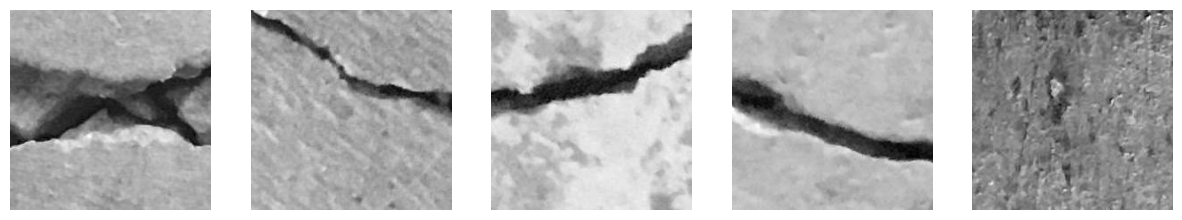

In [26]:
import torch
import matplotlib.pyplot as plt

# Function to display images from a batch
def show_images(batch):
    images = batch.squeeze().numpy()  # Remove channel dimension and convert to numpy array
    fig, axes = plt.subplots(1, len(images), figsize=(15, 15))  # Create a subplot for each image
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')  # Display each image in grayscale
        ax.axis('off')  # Hide axis for clean visualization
    plt.show()

# Get a batch of data from the DataLoader
data_loader = DataLoader(dataset, batch_size=5, shuffle=True)
batch = next(iter(data_loader))  # Get a batch of data

# Check if batch contains only images or more values
if isinstance(batch, torch.Tensor):  # If it's just the images
    images = batch
else:
    images = batch[0]  # If it's a tuple, take the first element as images

# Show the images
show_images(images)


In [28]:
# Save the trained model
torch.save(model.state_dict(), 'vae_model.ipynb')

# Download the model file to your local system
from google.colab import files
files.download('vae_model.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>